## RNAseq analysis workflow using DEseq2

This scripts aims to use the DEseq2 R package for Differential gene expression. The result will be a deeper insight on the genes that are up-regulated and down-regulated as well as some important findings. As a small recap on the data that I am using: 2 replicates of Control samples(DMSO) and 2 replicates of experimental samples(CBD) on primary human keratinocytes,cells on the outermost layer of the skin .

In [1]:
library("DESeq2")
library(scales)
options(repr.plot.width=6, repr.plot.height=5)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: ‘S4Vectors’


The

In [2]:
getwd()

[1] "/mnt/storage/r0771801/jupyternotebooks/kristen_ass1"

Define the proper raw counts derived using the previous bash script/jupyternotebookDefine the proper raw counts derived using the previous bash <font color=green>kristen_rnaseq_map</font> script/jupyternotebook

In [3]:
matrixFile = path.expand("/mnt/storage/r0771801/jupyternotebooks/kristen_ass1/all.gene.counts")

Count for each gene in each of the bam file:  
<font color=green>SRR9102523_1_C1</font>-Control replicate 1  
<font color=green>SRR9102524_1_C2</font>-Control replicate 2  
<font color=green>SRR9102526_1_CBD1</font>-Experimental replicate 1  
<font color=green>SRR9102527_1_CBD2</font>-Experimental replicate 2  

In [4]:
countData <- as.matrix(read.csv(matrixFile, sep="\t", row.names="Geneid"))
head(countData)

,SRR9102523_1_C1.bam,SRR9102524_1_C2.bam,SRR9102526_1_CBD1.bam,SRR9102527_1_CBD2.bam
MIR1302-11,0,0,0,0
FAM138A,0,0,0,0
OR4F5,0,0,0,0
RP11-34P13.7,0,0,0,2
RP11-34P13.8,0,0,0,0
AL627309.1,80,54,144,152


In [5]:
colnames(countData) <- c("C1", "C2", "CBD1", "CBD2")
head(countData)

,C1,C2,CBD1,CBD2
MIR1302-11,0,0,0,0
FAM138A,0,0,0,0
OR4F5,0,0,0,0
RP11-34P13.7,0,0,0,2
RP11-34P13.8,0,0,0,0
AL627309.1,80,54,144,152


In [6]:
countData['BACH1',]

C1   C2 CBD1 CBD2 
2632 2379 4763 4612

We can plot the total amount of reads per sample, they should be somewhat the same

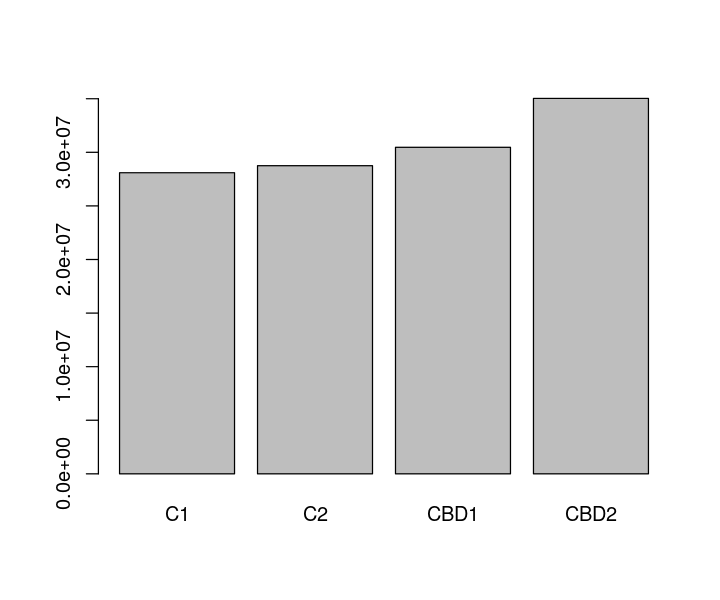

In [7]:
barplot(colSums(countData))

it is important that the order of the levels is correct. In this case `C` comes first, which means that we will be comparing $CB \over C$, so positive log fold change values are up in the stiumulated samples.

In [8]:
condition <- factor(c("C", "C", "CBD", "CBD"))
print(condition)

[1] C   C   CBD CBD
Levels: C CBD


In [9]:
colData <- data.frame(sampleName = colnames(countData),
                      condition = condition)
colData

sampleName,condition
<fct>,<fct>
C1,C
C2,C
CBD1,CBD
CBD2,CBD


We create the `DESeqDataSet` for further analysis

In [10]:
dds <- DESeqDataSetFromMatrix(countData = countData,
                              colData = colData,
                              design = ~ condition)
#we need to do this to ensure the column names are correct.
colnames(dds) <- colnames(countData)

In [11]:
dds

class: DESeqDataSet 
dim: 41863 4 
metadata(1): version
assays(1): counts
rownames(41863): MIR1302-11 FAM138A ... AC007965.1 RNU6-1314P
rowData names(0):
colnames(4): C1 C2 CBD1 CBD2
colData names(2): sampleName condition

In [12]:
dds$condition

[1] C   C   CBD CBD
Levels: C CBD

## Run the differential expression

Negative Binomial Models include:  
<font color=red>edgeR</font>  
<font color=red>DeSeq2</font>  
<font color=red>baySeq2</font>  

In [13]:
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Normalization is needed to compare samples and genes. I have included a few of biases that require normalization:  
- Sequencing depth 
- Gene length
- Differences in count distribution
- Sequencing bias  

The DESeq2 model internally corrects for **library size** so the input must be un-normalized counts

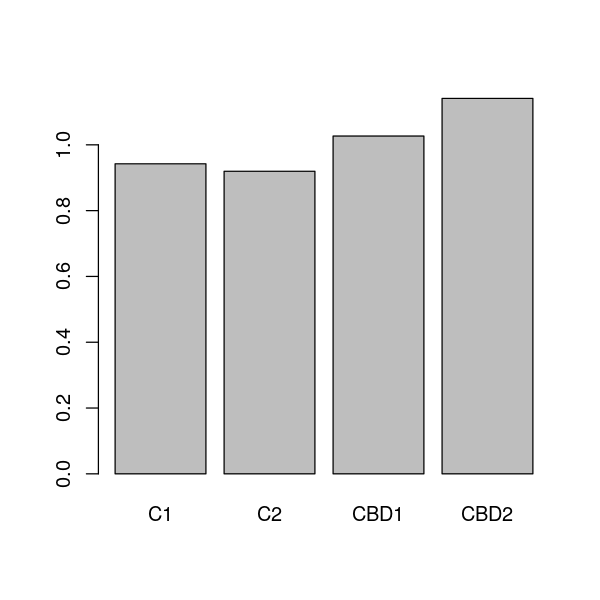

In [14]:
options(repr.plot.width=5, repr.plot.height=5)
barplot(sizeFactors(dds))

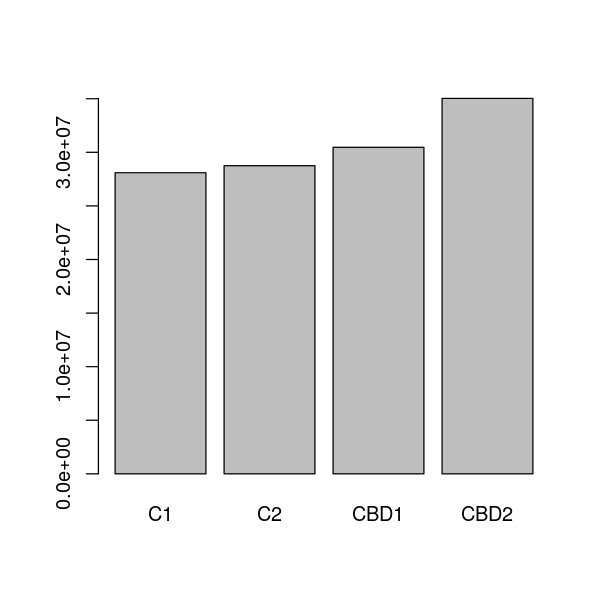

In [15]:
barplot(colSums(countData))

We can plot a `pairs` plot to show us how the samples compare. *Are the replicates more simiar that betweeen stimulated and non-stimulated?*  
These are 2Log Counts for the samples vs its tecnical replicate( <font color=orange>*C1* vs *C2*</font> and <font color=orange>*CBD1* vs *CBD2*</font>). We notice the small range, the small amount of discontinuity at the lower counts but overall the high reproducibility.

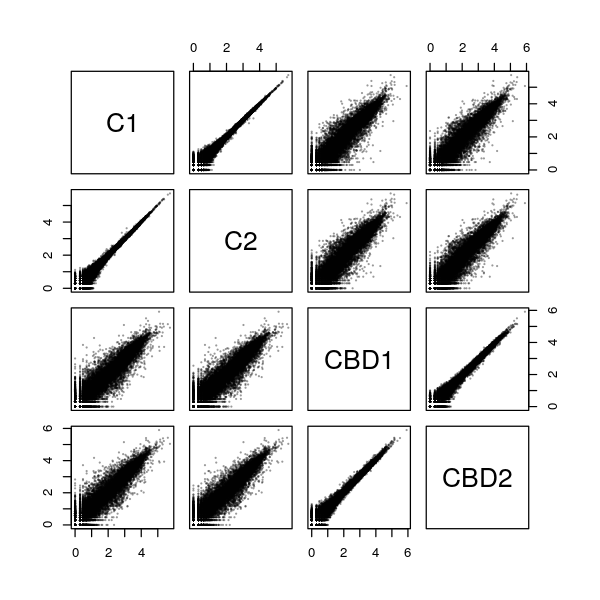

In [16]:
options(repr.plot.width=5, repr.plot.height=5)
plot(data.frame(log10(counts(dds))), cex=0.1, col=alpha("black", 0.4))

## MA Plot

MA plots : **M** values( log base 2 fold change between treatments) on the yaxis and  the mean of the normalized counts(**A**bundance)  on the x-axis  
This plot aims to determine how different the samples/datasets are in terms of the read counts. Each gene is represented by a dot in the figure below. We generally work under the assumption that all genes have a fold change of 0 and not chaning between experiments. Red points indicate genes with significant p-values and therefore differentially expressed genes.

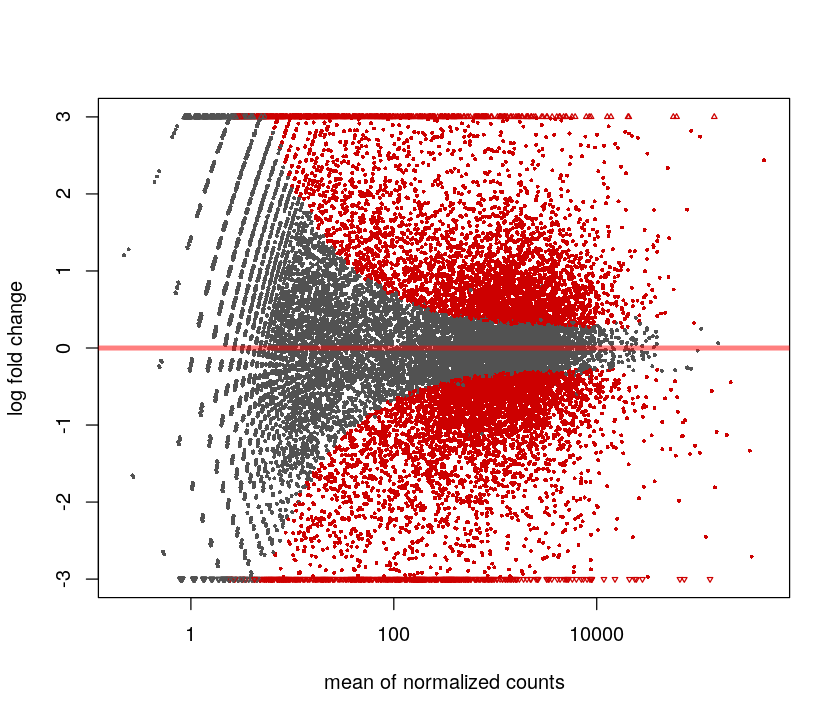

In [44]:
options(repr.plot.width=7, repr.plot.height=6)
plotMA(dds,ylim=c(-3,3),main="MAplot after DESeq2 analysis")

### Export the results

In [18]:
norm_matrix_deseq=counts(dds,normalized=T)
write.table(file="norm_matrix_deseq.tsv",norm_matrix_deseq,sep="\t",quote=F)
colnames(norm_matrix_deseq)

[1] "C1"   "C2"   "CBD1" "CBD2"

In [19]:
res <- results(dds)
res <- res[order(res$padj),]
head(res)

log2 fold change (MLE): condition CBD vs C 
Wald test p-value: condition CBD vs C 
DataFrame with 6 rows and 6 columns
                 baseMean    log2FoldChange             lfcSE              stat
                <numeric>         <numeric>         <numeric>         <numeric>
MMP1     61297.5760011357  6.85574099407745 0.147260164528286  46.5552990249483
COL5A3   7381.62712453213 -7.52893907750159  0.18306113385365  -41.128004175483
ADAMTS12 5202.23015480467 -6.74188918108058 0.188006046750936 -35.8599592810545
IFIT1    3212.81047602838 -6.24139623943382 0.186159204823956 -33.5271964947211
PDGFRB   8035.26233388294 -5.62222825307366 0.169721559799672 -33.1261877377851
MT1G     7894.03827200318  9.67073982532403 0.301410644414745  32.0849313205309
                        pvalue                  padj
                     <numeric>             <numeric>
MMP1                         0                     0
COL5A3                       0                     0
ADAMTS12 1.28644485743015e-28

How many genes are differentially expressed?  
7937! That's a lot! This large number accounts for the large number of red points that was previously visualized using the MA plot

In [20]:
res.sign <- res[(!is.na(res$padj)) & (res$padj < 0.05),]
dim(res.sign)
head(res.sign)

[1] 7937    6

log2 fold change (MLE): condition CBD vs C 
Wald test p-value: condition CBD vs C 
DataFrame with 6 rows and 6 columns
                 baseMean    log2FoldChange             lfcSE              stat
                <numeric>         <numeric>         <numeric>         <numeric>
MMP1     61297.5760011357  6.85574099407745 0.147260164528286  46.5552990249483
COL5A3   7381.62712453213 -7.52893907750159  0.18306113385365  -41.128004175483
ADAMTS12 5202.23015480467 -6.74188918108058 0.188006046750936 -35.8599592810545
IFIT1    3212.81047602838 -6.24139623943382 0.186159204823956 -33.5271964947211
PDGFRB   8035.26233388294 -5.62222825307366 0.169721559799672 -33.1261877377851
MT1G     7894.03827200318  9.67073982532403 0.301410644414745  32.0849313205309
                        pvalue                  padj
                     <numeric>             <numeric>
MMP1                         0                     0
COL5A3                       0                     0
ADAMTS12 1.28644485743015e-28

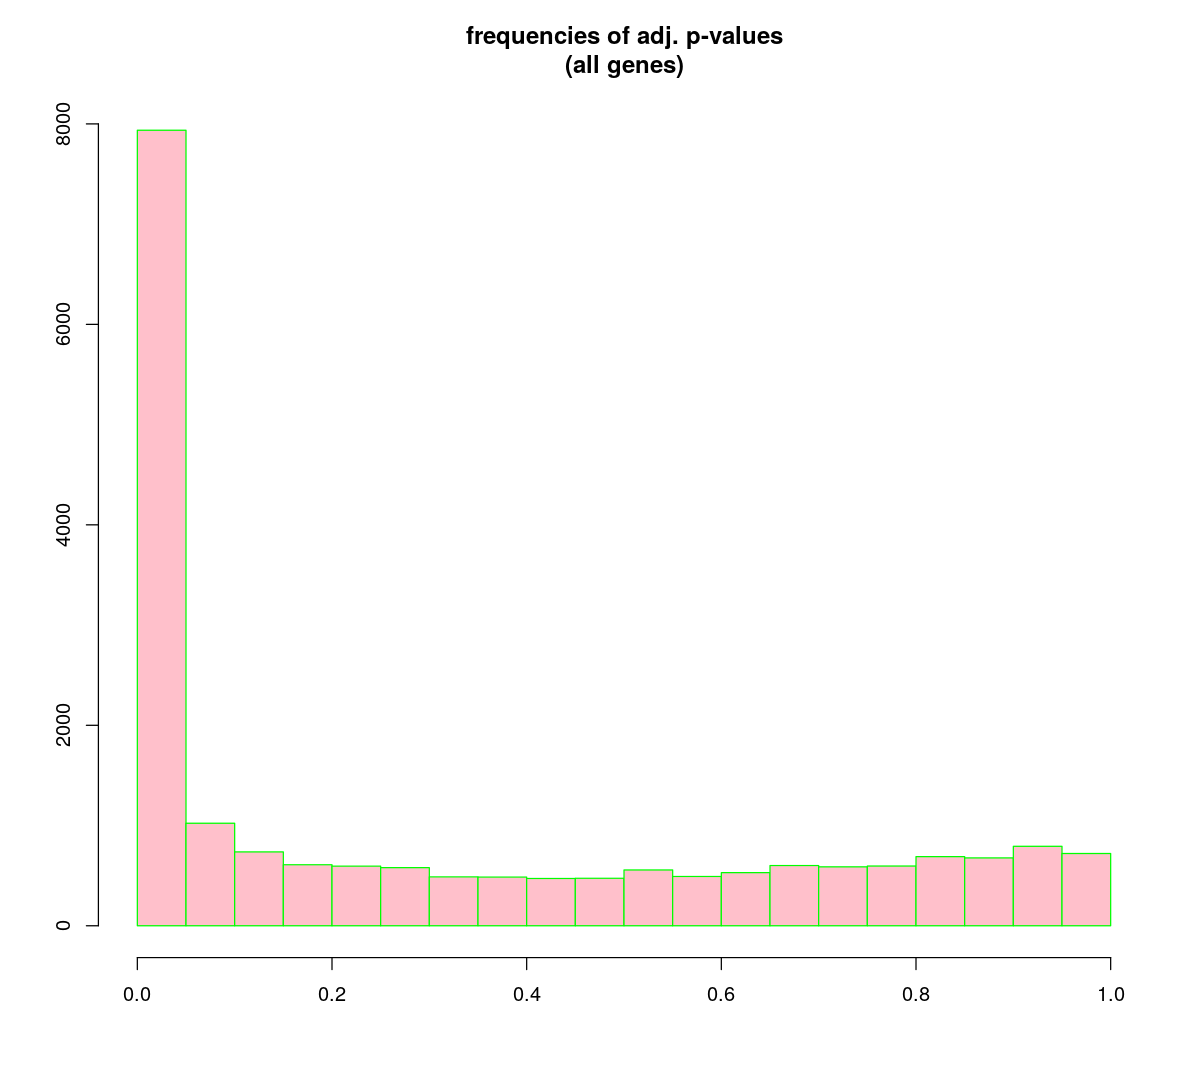

In [51]:
options(repr.plot.width=10, repr.plot.height=9)
hist(res$padj, 
     col="pink", border="green", xlab="", ylab="", main="frequencies of adj. p-values\n(all genes)")

The plots below represent thr normalized Counts for a specific gene on a log scale. We visualize the most important genes her : HMOX1 and BACH1.

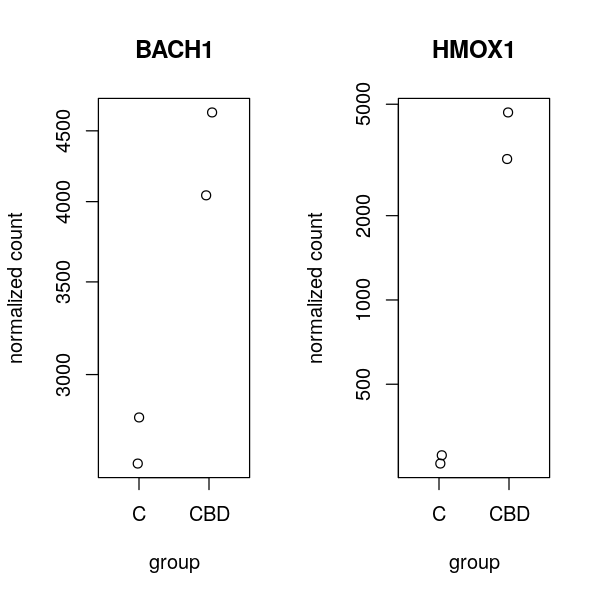

In [22]:
par(mfrow=c(1,2))
plotCounts(dds,gene="BACH1", normalized=TRUE)
plotCounts(dds,gene="HMOX1", normalized=TRUE)

We save the results to view and use them later.

In [23]:
write.table(res, "deseq.results.tsv", sep="\t", col.names=NA, quote=FALSE)

We should always chech the number of differentially expressed genes:
<font color=blue>*BACH1*</font>?  
Bach1 is a transcription regulator and is involved in maintaining mitotic chromosome alignment. We see that it has a positivee logFC and a significant p-value and therefore is determined to be up-regulated.

In [24]:
res['BACH1',]

log2 fold change (MLE): condition CBD vs C 
Wald test p-value: condition CBD vs C 
DataFrame with 1 row and 6 columns
              baseMean    log2FoldChange             lfcSE             stat
             <numeric>         <numeric>         <numeric>        <numeric>
BACH1 3515.16763658774 0.690128735315072 0.149143345464418 4.62728479883617
                    pvalue                padj
                 <numeric>           <numeric>
BACH1 3.70490879699514e-06 1.9435684439457e-05

<font color=blue>*HMOX1*</font>?  
This is a gene encoding for a Heme oxygenase 1, a stress inducible enzyme. This catalyzes the rate -limiting reation in heme catabolism and has important anti-inflammatory properties. It is highly induced under cellular stress contintions such as oxidatve stress, heavy metals...etc.  
HMOX1 is positively regulated by NFR2(NFE2L2) and down-regulated by BACH1.

In [25]:
res['HMOX1',]

log2 fold change (MLE): condition CBD vs C 
Wald test p-value: condition CBD vs C 
DataFrame with 1 row and 6 columns
              baseMean   log2FoldChange             lfcSE             stat
             <numeric>        <numeric>         <numeric>        <numeric>
HMOX1 2099.48830022592 3.86774422299865 0.198433700338291 19.4913677283894
                    pvalue                padj
                 <numeric>           <numeric>
HMOX1 1.29960676685583e-84 3.1915093177062e-82

<font color=blue>*HPRT1*</font>?  
This is a housekeeping gene that is used as an internal control in the paper

In [26]:
res['HPRT1',]

log2 fold change (MLE): condition CBD vs C 
Wald test p-value: condition CBD vs C 
DataFrame with 1 row and 6 columns
             baseMean   log2FoldChange             lfcSE              stat
            <numeric>        <numeric>         <numeric>         <numeric>
HPRT1 798.97358444228 -1.4723502552489 0.183884004353171 -8.00695123226203
                   pvalue                 padj
                <numeric>            <numeric>
HPRT1 1.1758709247769e-15 1.70362538260818e-14

I thought this was very interesting. According to a quick research, I would expect CBD to activate a subset of NF2 genes which in turn would downregulate the expression of BACH1. BACH1 usually downregulates HMOX1 and thus inhibits the transcription of  oxidative stress-response genes(HMOX1) **but** CBD is expected to cause an up-regulation of HMOX1 and thus a downregulation of BACH1. According to the plots, the logFC, counts and the p-values: BACH1 still appears to be up-regulated. We can see in the plots below, a few target genes that were of interest. As stated earlier, HMOX1 is expected to be upregulated in the experimental data but BACH1 is expected to be lower in counts.  
The graphs below show the counts for each gene as a way to visualize which genes would be expected to be up-regulated and down-regulated. I have given a brief explanation on some of the genes:  
<font color=blue>*GCLC*</font>: NFR2 target gene   
<font color=blue>*SQSTM1*</font> : ubiquitin-binding protein p62 and also a NFR2 target gene  
<font color=blue>*NFE2L2*</font> : nuclear factor erythroid-derived 2-like 2 encodes a transciption factor (NFE2L2/NRF2 pathway)  

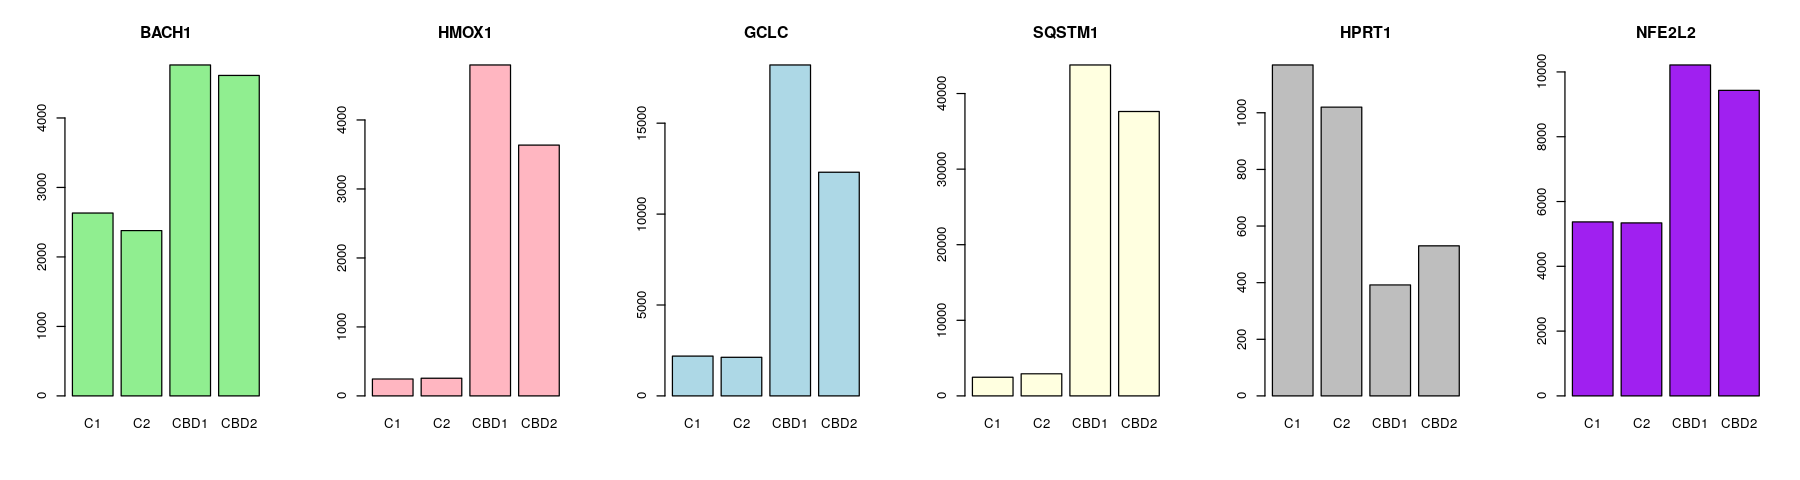

In [29]:
par(mfrow=c(1,6))
options(repr.plot.width=15, repr.plot.height=4)
barplot(counts(dds)["BACH1",],main="BACH1",col="light green")
barplot(counts(dds)["HMOX1",],main="HMOX1",col="light pink")
barplot(counts(dds)["GCLC",],main="GCLC",col="light blue")
barplot(counts(dds)["SQSTM1",],main="SQSTM1",col="light yellow")
barplot(counts(dds)["HPRT1",],main="HPRT1",col="grey")
barplot(counts(dds)["NFE2L2",],main="NFE2L2",col="purple")

I further looked at the antisense RNA 1,  intronic transcript (1,2,3) and found the same results. This further confused me. However, upon reading more articles on the BACH1-HMOX1 pathways I discovered that CBD(experimental) was involved in the nuclear export and degradation of BACH1, a transcription repressor of HMOX1( an important detail)! Therefore, by exporting BACH1 out of the nucleus, it is unable to repress HMOX1 expression. Therefore, BACH1 is not down-regulated and finding a significant p-value and positive logFC is logical.

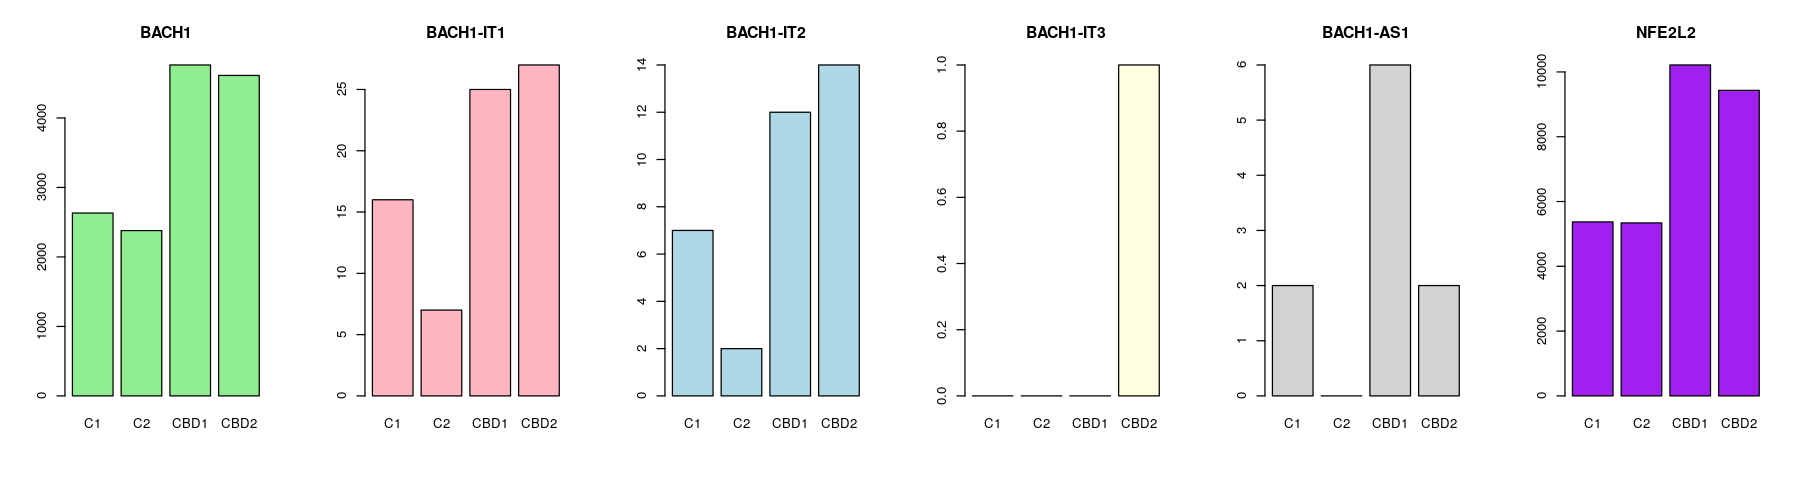

In [30]:
par(mfrow=c(1,6))
options(repr.plot.width=15, repr.plot.height=4)
barplot(counts(dds)["BACH1",],main="BACH1",col="light green")
barplot(counts(dds)["BACH1-IT1",],main="BACH1-IT1",col="light pink")
barplot(counts(dds)["BACH1-IT2",],main="BACH1-IT2",col="light blue")
barplot(counts(dds)["BACH1-IT3",],main="BACH1-IT3",col="light yellow")
barplot(counts(dds)["BACH1-AS1",],main="BACH1-AS1",col="light grey")
barplot(counts(dds)["NFE2L2",],main="NFE2L2",col="purple")

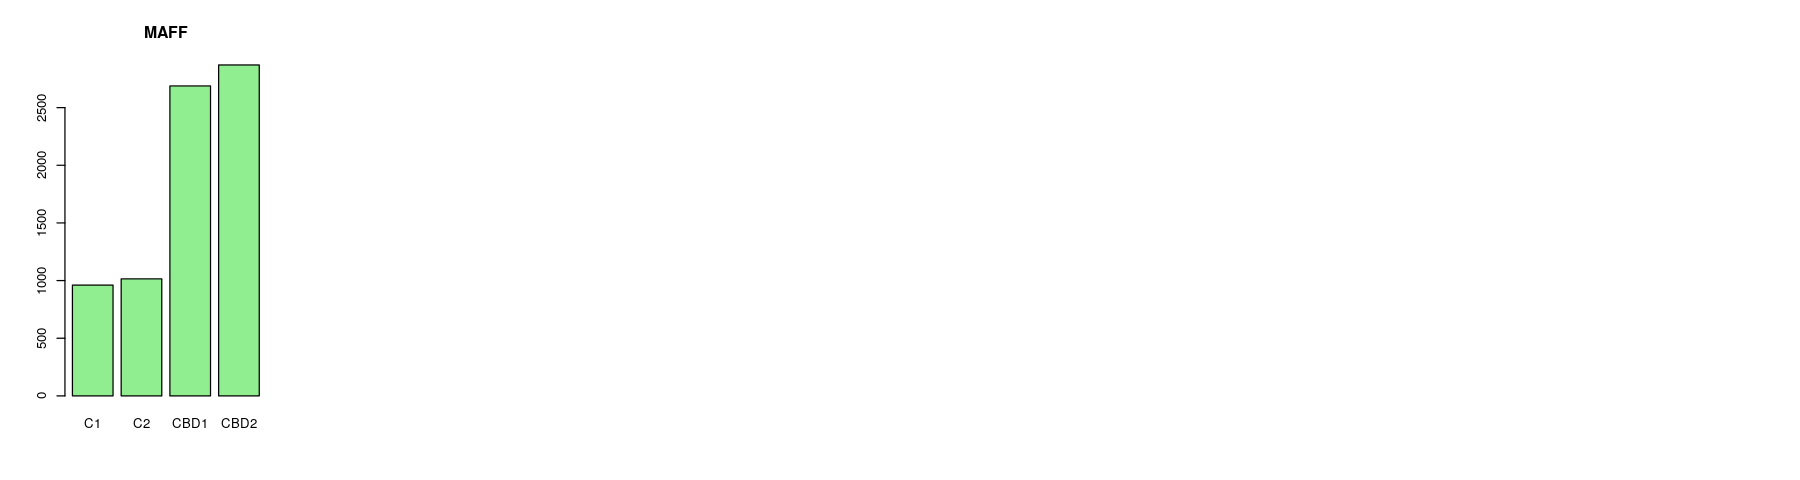

In [40]:
par(mfrow=c(1,6))
options(repr.plot.width=15, repr.plot.height=4)
barplot(counts(dds)["MAFF",],main="MAFF",col="light green")

In order to help me understand more about the general pathways, I found this image in a [Review paper](https://doi.org/10.1155/2018/1347969)  that I will briefly explain: 

In an situation without oxidative stress, Nrf2 is bound by KEAP2 which faciliates its degradation in the cytoplasm. During oxidative stress, Nrf2 dissocaites from Keap1 and accululates in the cytoplasm where it is then transported into the nucleus. Nrf2/nuclear factor, erythroid 2 like 2/NFE2L2, now in the nucleus, binds to MAREs(Maf recognition elements) with small protein Maf therefore activating HMOX1, a gene important iin oxidative stress response. BACH1 competes with Nrf for binding to MAREs.
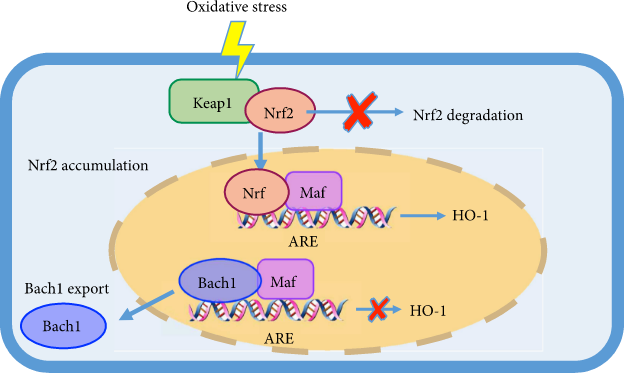



In [32]:
res.sorted <- res[order(res$padj),]
head(res.sorted)

log2 fold change (MLE): condition CBD vs C 
Wald test p-value: condition CBD vs C 
DataFrame with 6 rows and 6 columns
                 baseMean    log2FoldChange             lfcSE              stat
                <numeric>         <numeric>         <numeric>         <numeric>
MMP1     61297.5760011357  6.85574099407745 0.147260164528286  46.5552990249483
COL5A3   7381.62712453213 -7.52893907750159  0.18306113385365  -41.128004175483
ADAMTS12 5202.23015480467 -6.74188918108058 0.188006046750936 -35.8599592810545
IFIT1    3212.81047602838 -6.24139623943382 0.186159204823956 -33.5271964947211
PDGFRB   8035.26233388294 -5.62222825307366 0.169721559799672 -33.1261877377851
MT1G     7894.03827200318  9.67073982532403 0.301410644414745  32.0849313205309
                        pvalue                  padj
                     <numeric>             <numeric>
MMP1                         0                     0
COL5A3                       0                     0
ADAMTS12 1.28644485743015e-28

# Use a Shrunken LogFC

In order to generate more accuate estimates of the LogFC, we can shrink the logFC estimates towards zero. This can be done for genes with low counts or high dispersion values. The distibution of the logFC estimates for all genes is used to shrink estimates for genes with low counts towards values. In the recent version of DESeq2 , shrinking is not done automatically. According to the developer, Michael Love the shrunken fold changes are useful for ranking genes by effect size and for visualization.

In [33]:
contrasts=c("condition","CBD","C")
contrasts
mod_res=results(dds,alpha=0.05)
shrunken=lfcShrink(dds, contrast=contrasts, res=mod_res)

[1] "condition" "CBD"       "C"

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



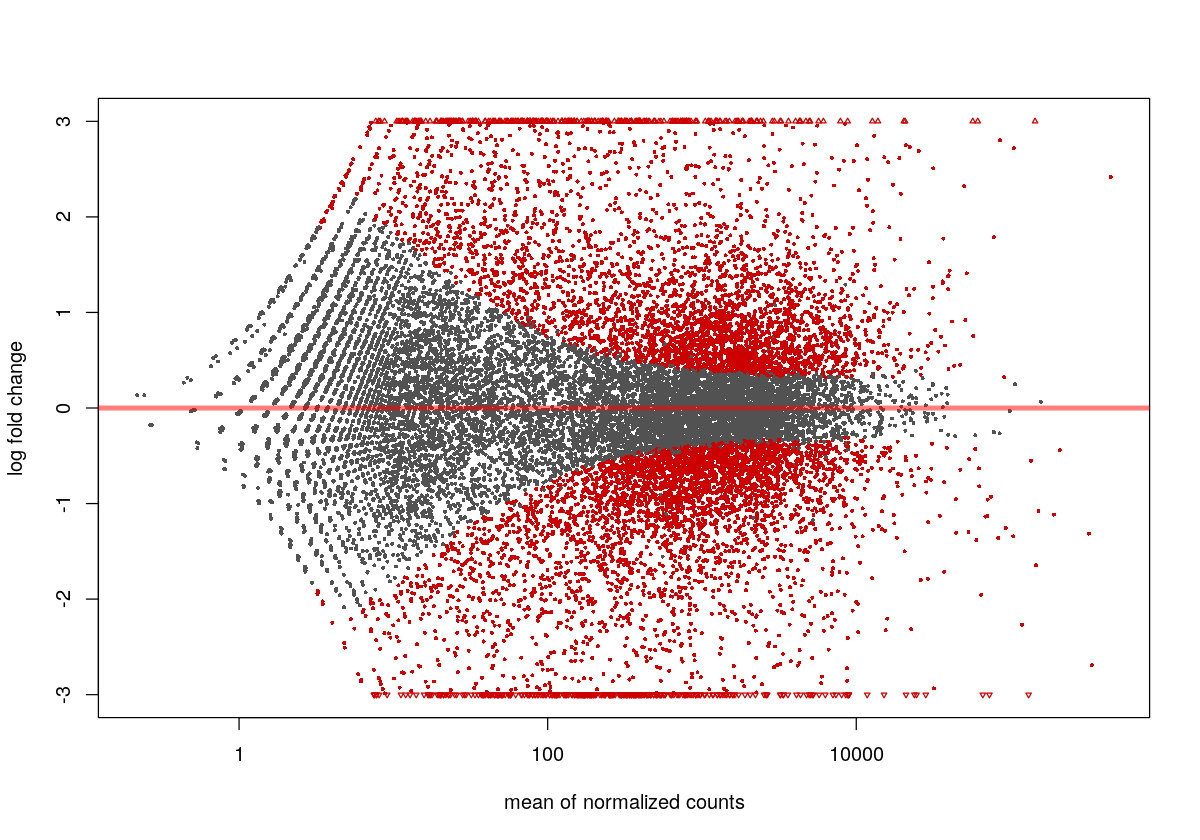

In [35]:
options(repr.plot.width=10,repr.plot.height=7)
plotMA(shrunken,ylim=c(-3,3))

In [36]:
result_new=shrunken[order(shrunken$padj),]
head(result_new)

log2 fold change (MAP): condition CBD vs C 
Wald test p-value: condition CBD vs C 
DataFrame with 6 rows and 6 columns
                 baseMean    log2FoldChange             lfcSE              stat
                <numeric>         <numeric>         <numeric>         <numeric>
MMP1     61297.5760011357    6.807285212976  0.14615758939569  46.5552990249483
COL5A3   7381.62712453213 -7.44742505038672 0.179864205736432  -41.128004175483
ADAMTS12 5202.23015480467 -6.66484979271082 0.184989717422796 -35.8599592810545
IFIT1    3212.81047602838 -6.17129317819671 0.183124026194051 -33.5271964947211
PDGFRB   8035.26233388294 -5.56961496612947 0.167962853172288 -33.1261877377851
MT1G     7894.03827200318  9.40047570232089 0.279940261836586  32.0849313205309
                        pvalue                  padj
                     <numeric>             <numeric>
MMP1                         0                     0
COL5A3                       0                     0
ADAMTS12 1.28644485743015e-28

In [37]:
res['BACH1',]
result_new['BACH1',]


log2 fold change (MLE): condition CBD vs C 
Wald test p-value: condition CBD vs C 
DataFrame with 1 row and 6 columns
              baseMean    log2FoldChange             lfcSE             stat
             <numeric>         <numeric>         <numeric>        <numeric>
BACH1 3515.16763658774 0.690128735315072 0.149143345464418 4.62728479883617
                    pvalue                padj
                 <numeric>           <numeric>
BACH1 3.70490879699514e-06 1.9435684439457e-05

log2 fold change (MAP): condition CBD vs C 
Wald test p-value: condition CBD vs C 
DataFrame with 1 row and 6 columns
              baseMean    log2FoldChange             lfcSE             stat
             <numeric>         <numeric>         <numeric>        <numeric>
BACH1 3515.16763658774 0.685126524866705 0.148061244991457 4.62728479883617
                    pvalue                 padj
                 <numeric>            <numeric>
BACH1 3.70490879699514e-06 1.89370798910764e-05

log2 fold change (MLE): condition CBD vs C 
Wald test p-value: condition CBD vs C 
DataFrame with 1 row and 6 columns
               baseMean    log2FoldChange             lfcSE             stat
              <numeric>         <numeric>         <numeric>        <numeric>
NFE2L2 7430.51763285985 0.662735650097364 0.148130437586424 4.47400048832436
                     pvalue                 padj
                  <numeric>            <numeric>
NFE2L2 7.67695660670054e-06 3.84552497438141e-05

In [38]:
write.table(result_new, "deseq.shrunken.results.tsv", sep="\t", col.names=NA, quote=FALSE)